In [1]:
# To work scipy appropriately, you need to have numpy, scipy and statsmodel with their newest versions
# For statsmodel: pip install git+http://github.com/statsmodels/statsmodels.git@master

import os
import time
import numpy as np
import pandas as pd
import geosnap
from osnap.data import read_ltdb
from tobler.area_weighted import *
import geopandas as gpd
from quilt.data.spatialucr import census
from shapely.wkb import loads
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

os.chdir('C:\\Users\\renan\\Desktop\\osnap_data')

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\pysal\__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


The data used follows geosnap guidelines: https://github.com/spatialucr/geosnap/tree/master/geosnap/data

In [2]:
sample = "LTDB_Std_All_Sample.zip"
full = "LTDB_Std_All_fullcount.zip"

df_pre = read_ltdb(sample = sample, fullcount = full)

- The Philadelphia County is the code '42101' (State Code + County Code): https://en.wikipedia.org/wiki/List_of_counties_in_Pennsylvania

- 'x_white_under_15' is a variable that is present in all census data to be harmonized

In [3]:
df = df_pre.copy()

df['geoid'] = df.index
df['state'] = df['geoid'].str[0:2]
#df_phili_2010 = df[(df['year'] == 2010)][['geoid', 'n_total_pop', 'n_white_under_15', 'p_white_under_15']]
df_phili_2010 = df[(df['year'] == 2010) & (df.geoid.str[0:5] == '42101')][['geoid', 'n_total_pop', 'n_white_under_15', 'p_white_under_15']]

In [4]:
df_2000 = geosnap.data.db.census_00[['geoid', 'n_total_pop', 'n_white_under_15', 'p_white_under_15']]
df_2000['geoid'] = [str(item).zfill(11) for item in list(df_2000.geoid.astype(str))]

In [5]:
df_phili_2000 = df_2000[df_2000.geoid.str[0:5] == '42101']

Getting the raw census tracts for all years:

In [6]:
df = census.tracts_1990()
df['geometry'] = df.wkb.apply(lambda x: loads(x, hex=True))
gdf_1990 = gpd.GeoDataFrame(df)
gdf_1990['year'] = '1990'
gdf_1990.head()

,geoid,index,wkb,geometry,year
0,01023009567,None,0103000000010000007B070000DC9C4A06801A56C08C85...,"POLYGON ((-88.414064 32.179518, -88.414226 32....",1990
1,01023009568,None,010300000001000000F6090000A3E5400FB51456C02462...,"POLYGON ((-88.32355099999999 32.02982, -88.324...",1990
2,01023009569,None,0103000000010000008B040000840EBA84431D56C001C1...,"POLYGON ((-88.457246 31.81052, -88.458158 31.8...",1990
3,01023009570,None,01030000000100000082020000FA7C9411170C56C00E88...,"POLYGON ((-88.188908 31.698461, -88.194 31.698...",1990
0,01037009610,None,01030000000100000032030000A62BD8463C8655C0950C...,"POLYGON ((-86.09742900000001 32.912974, -86.09...",1990


In [7]:
df = census.tracts_2000()
df['geometry'] = df.wkb.apply(lambda x: loads(x, hex=True))
gdf_2000 = gpd.GeoDataFrame(df)
gdf_2000['year'] = '2000'
gdf_2000.head()

,geoid,wkb,geometry,year
0,01071950100,01030000000100000030020000A51133FB3C6A55C05517...,"POLYGON ((-85.659972 34.755957, -85.660201 34....",2000
1,01071950200,0103000000010000006B0100009E5DBEF5617155C0B136...,"POLYGON ((-85.771604 34.917734, -85.772938 34....",2000
2,01071950300,01030000000100000033030000D76D50FBAD8155C02A58...,"POLYGON ((-86.02624400000001 34.783033, -86.02...",2000
3,01071950400,010300000001000000E50400008461C092AB9455C05281...,"POLYGON ((-86.32297199999999 34.741224, -86.32...",2000
4,01071950500,010300000001000000080300000F98874CF98A55C032E7...,"POLYGON ((-86.171466 34.621673, -86.1737300000...",2000


In [8]:
df = census.tracts_2010()
df['geometry'] = df.wkb.apply(lambda x: loads(x, hex=True))
gdf_2010 = gpd.GeoDataFrame(df)
gdf_2010['geoid'] = gdf_2010['GEOID']
gdf_2010['year'] = '2010'
gdf_2010.head()

,GEOID,wkb,geometry,geoid,year
0,47157007300,01030000000100000098000000EA03C93B877C56C001BD...,"POLYGON ((-89.94575399999999 35.115323, -89.94...",47157007300,2010
1,47157021320,010300000001000000EB000000B11875ADBD7756C0A033...,"POLYGON ((-89.870952 35.089518, -89.8707709999...",47157021320,2010
2,47157020222,0103000000010000001A0300003D4162BB7B7B56C0562B...,"POLYGON ((-89.92942699999999 35.262985, -89.92...",47157020222,2010
3,47157022410,010300000001000000A101000067EF8CB62A8856C05FED...,"POLYGON ((-90.127607 34.994684, -90.127318 34....",47157022410,2010
4,47157005300,0103000000010000003601000082531F48DE8556C0FDA1...,"POLYGON ((-90.09169199999999 35.084691, -90.09...",47157005300,2010


In [9]:
full_phili_2000 = gdf_2000.merge(df_phili_2000, on = 'geoid')
full_phili_2010 = gdf_2010.merge(df_phili_2010, on = 'geoid')

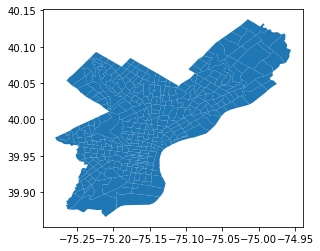

In [10]:
phili_1990 = gdf_1990[gdf_1990.geoid.str[0:5] == '42101']
#phili_1990 = gdf_1990
phili_1990.plot()

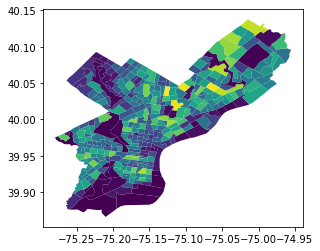

In [11]:
full_phili_2000.plot(column = 'n_total_pop')

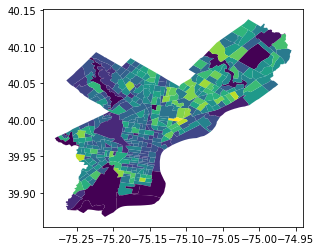

In [12]:
full_phili_2010.plot(column = 'n_total_pop')

In [13]:
#from tobler.harmonize import *

In [14]:
phili_1990.crs = full_phili_2000.crs = full_phili_2010.crs = {'init': 'epsg:4326'}

In [15]:
#old = area_interpolate(full_phili_2000, phili_1990,  extensive_variables = ['n_total_pop'], intensive_variables = ['p_white_under_15'])

In [16]:
#new = area_interpolate_binning(full_phili_2000, phili_1990,  extensive_variables = ['n_total_pop'], intensive_variables = ['p_white_under_15'])

In [17]:
print('N. of tracts in 1990 (reference year): {} \nN. of tracts in 2000: {} \nN. of tracts in 2010: {}'.format(len(phili_1990), len(full_phili_2000), len(full_phili_2010)))

N. of tracts in 1990 (reference year): 367 
N. of tracts in 2000: 381 
N. of tracts in 2010: 384


In [18]:
# from geosnap.harmonize import harmonize

# Harmonizing the geodataframes with the area methods 

## area_tables + area_interpolate

In [19]:
from tobler import harmonize

In [20]:
import time
t0 = time.time()
raw_community = [phili_1990, full_phili_2000, full_phili_2010]
harmonized_area = harmonize(raw_community,
                            target_year_of_reference = '1990',
                            extensive_variables = ['n_total_pop', 'n_white_under_15'],
                            intensive_variables = ['p_white_under_15'],
                            weights_method = 'area')
t1 = time.time()
t1 - t0

Starting to Harmonize the year of 2000...
nan values in variable: p_white_under_15, replacing with 0.0
Harmonizing extensive variable n_total_pop of the year 2000.
Harmonizing extensive variable n_white_under_15 of the year 2000.
Harmonizing intensive variable p_white_under_15 of the year 2000.
Starting to Harmonize the year of 2010...
nan values in variable: p_white_under_15, replacing with 0.0
Harmonizing extensive variable n_total_pop of the year 2010.
Harmonizing extensive variable n_white_under_15 of the year 2010.
Harmonizing intensive variable p_white_under_15 of the year 2010.


5.14061164855957

In [21]:
harmonized_area.head()

,geoid,index,wkb,geometry,year,interpolated_n_total_pop,interpolated_n_white_under_15,interpolated_p_white_under_15
0,42101000001,None,010300000001000000320000005396218E75C952C0287E...,"POLYGON ((-75.1478 39.9486, -75.14919999999999...",2000,2692.555587,1364.565915,1.316683
1,42101000002,None,010300000001000000270000001904560E2DCA52C099BB...,"POLYGON ((-75.15900000000001 39.9536, -75.1594...",2000,37.926295,6.785932,NaN
2,42101000003,None,0103000000010000002D0000008FC2F5285CCB52C06E34...,"POLYGON ((-75.17749999999999 39.9551, -75.1776...",2000,NaN,NaN,NaN
3,42101000004,None,0103000000010000002D0000006C09F9A067CB52C08BFD...,"POLYGON ((-75.1782 39.9523, -75.17919999999999...",2000,NaN,NaN,NaN
4,42101000005,None,0103000000010000002000000068B3EA73B5C952C036CD...,"POLYGON ((-75.15170000000001 39.9517, -75.152 ...",2000,NaN,NaN,NaN


# Harmonizing the geodataframes with the National Land Cover area methods 

## area_tables_nlcd + area_interpolate

In [22]:
filepath = 'C:\\Users\\renan\\Desktop\\harmonization_osnap\\NLCD2011_LC_Pennsylvania\\NLCD2011_LC_Pennsylvania.tif'
#filepath = '~/NLCD2011_LC_Pennsylvania.tif'

In [23]:
import rasterio
from rasterio.plot import show

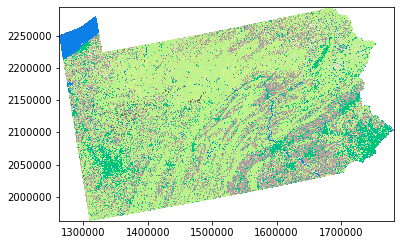

In [24]:
penn_raster = rasterio.open(filepath)
show(penn_raster, cmap='terrain')

In [25]:
phili_1990.crs = {'init': 'epsg:4326'}
full_phili_2000.crs = {'init': 'epsg:4326'}
full_phili_2010.crs = {'init': 'epsg:4326'}

In [26]:
raw_community_with_crs = [phili_1990, full_phili_2000, full_phili_2010]

In [27]:
harmonized_nlcd = harmonize(raw_community_with_crs,
                            target_year_of_reference = '1990',
                            extensive_variables = ['n_total_pop', 'n_white_under_15'],
                            intensive_variables = ['p_white_under_15'],
                            weights_method = 'nlcd_land_type_area',
                            raster = penn_raster)

Starting to Harmonize the year of 2000...
Harmonizing extensive variable n_total_pop of the year 2000.
Harmonizing extensive variable n_white_under_15 of the year 2000.


IndexError: list index out of range

# Comparing both methods in terms of the values generated for all variables

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 7))
plt.scatter(harmonized_area.interpolated_n_total_pop, harmonized_nlcd.interpolated_n_total_pop)
plt.xlabel('Area Interpolated', fontsize = 18)
plt.ylabel('NLCD Interpolated (area)', fontsize = 18)

In [ ]:
plt.figure(figsize=(7, 7))
plt.scatter(harmonized_area.interpolated_n_white_under_15, harmonized_nlcd.interpolated_n_white_under_15)
plt.xlabel('Area Interpolated', fontsize = 18)
plt.ylabel('NLCD Interpolated (area)', fontsize = 18)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 7))
plt.scatter(harmonized_area.interpolated_p_white_under_15, harmonized_nlcd.interpolated_p_white_under_15)
plt.xlabel('Area Interpolated', fontsize = 18)
plt.ylabel('NLCD Interpolated (area)', fontsize = 18)